# Better Than New

This is one of the Jupyter notebooks I used in my preparation of *[Probably Overthinking It: How to Use Data to Answer Questions, Avoid Statistical Traps, and Make Better Decisions](https://greenteapress.com/wp/probably-overthinking-it)*, University of Chicago Press, 2023.

Before you read these notebooks, please keep in mind:

* There is some explanatory text here, but some of the examples will not make sense until you have read the corresponding chapter in the book.

* While preparing these notebooks, I made some changes to improve the readability of the code. There might be small differences between what appears in the book and what you get when you run the code.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ProbablyOverthinkingIt/blob/book/notebooks/nbue.ipynb).

In [67]:
# Install empiricaldist if we don't already have it

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [68]:
# download utils.py

from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download(
    "https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/notebooks/utils.py"
)

In [69]:
DATA_PATH = "https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/data/"

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.1)
sns.set(rc={'figure.figsize':(6, 3.5)})
sns.set_style('white')

# Set the random seed so we get the same results every time
np.random.seed(17)

In [71]:
import utils

def decorate(**options):
    utils.decorate(**options)
    sns.despine(left=True, bottom=True)

In [72]:
from utils import fit_normal
from utils import make_cdf
from utils import normal_error_bounds


def make_plot(series, model_label=None, plot_bounds=True, qs=None, **options):
    """Plot the data and a normal model.
    
    series: Series
    model_label: string
    plot_bounds: boolean, whether to plot the expected upper bound
    qs: sequence of quantities where the model should be evaluated
    options: passed to plt.plot
    """
    cdf = make_cdf(series)
    dist = fit_normal(series)
    p = 1 - (1 / len(series))
    upper = dist.ppf(p)

    if plot_bounds:
        plt.plot(upper, p * 100, "+", color="black", ms=12)

    n = len(series)
    if qs is None:
        q_max = max(cdf.qs.max(), upper)
        qs = np.linspace(cdf.qs.min(), q_max)
    low, high = normal_error_bounds(dist, n, qs)
    plt.fill_between(qs, low * 100, high * 100, lw=0, color="gray", alpha=0.2)

    cdf.plot(**options)

In [73]:
def savefig(filename, **options):
    if 'dpi' not in options:
        options['dpi'] = 300
    plt.savefig(filename, **options)

Suppose you work in a hospital, and one day you have lunch with three of your colleagues.
One is a facilities engineer working on a new lighting system, one is an obstetrician who works in the maternity ward, and one is an oncologist who works with cancer patients.
While you all enjoy the hospital food, each of them poses a statistical puzzle.

The engineer says they are replacing old incandescent light bulbs with LED bulbs, and they've decided to replace the oldest bulbs first.
According to previous tests, the bulbs last 1400 hours on average.
So, they ask, which do you think will last longer: a new bulb or one that has already been lit for 1000 hours?

Sensing a trick question, you ask if the new bulb might be defective.
The engineer says, no, let's assume we've confirmed that it works.
In that case, you say, I think the new bulb will last longer.

"That's right," says the engineer.
"Light bulbs behave as you expect; they wear out over time, so the longer they've been in use, the sooner they burn out, on average."

"However," says the obstetrician, "not everything works that way. 
For example, most often, pregnancy lasts 39 or 40 weeks.
Today I saw three patients who are all pregnant; the first is at the beginning of week 39, the second is at the beginning of week 40, and the third is at the beginning of week 41.
Which one do you think will deliver her baby first?"

Now you are sure it's a trick question, but just to play along, you say the third patient is likely to deliver first.

The obstetrician says no, the remaining duration of the three pregnancies is nearly the same, about four days.
Even taking medical intervention into account, all three have the same chance of delivering first.

"That's surprising," says the oncologist.
"But in my field things are even stranger.
For example, today I saw two patients with glioblastoma, which is a kind of brain cancer. They are about the same age, and the stage of their cancers is about the same, but one of them was diagnosed a week ago and one was diagnosed a year ago.
Unfortunately, the average survival time after diagnosis is only about a year.
So you probably expect the first patient to live longer."

By now you know better than to guess, so you wait for the answer.

The oncologist explains that many patients with glioblastoma live only a few months after diagnosis.
So, it turns out, a patient who survives one year after diagnosis is then *more* likely to survive a second year.

Based on this conversation, we can see that there are three ways survival times can go:

* Many things wear out over time, like light bulbs, so we expect something new to last longer than something old.

* But there are some situations, like patients after a cancer diagnosis, that are the other way around: the longer someone has survived, the longer we expect them to survive.

* And there are some situations, like women expecting babies, where the average remaining time doesn't change, at least for a while.

In this chapter I'll demonstrate and explain each of these effects, starting with light bulbs.

## Light Bulbs

The data are available in a gist:

In [399]:
download(
    "https://gist.github.com/epogrebnyak/7933e16c0ad215742c4c104be4fbdeb1/raw/c932bc5b6aa6317770c4cbf43eb591511fec08f9/lamps.csv"
)

In [400]:
df = pd.read_csv("lamps.csv", index_col=0)
df.tail()

,h,f,K
i,,,
28,1812,1,4
29,1836,1,3
30,1860,1,2
31,1980,1,1
32,2568,1,0


The `h` column contains the quantities; the `k` column contains the frequencies (counts).

In [401]:
from empiricaldist import Pmf

pmf_lifetimes = Pmf(df["f"].values, index=df["h"])
pmf_lifetimes.index.name = "t"

We can use a `Counter` to reconstitute the 50 individual lifetimes.

In [402]:
from collections import Counter

lifetimes = pd.Series(Counter(pmf_lifetimes.to_dict()).elements())
lifetimes.describe()

count      50.000000
mean     1413.840000
std       346.520628
min       840.000000
25%      1176.000000
50%      1446.000000
75%      1653.000000
max      2568.000000
dtype: float64

Here's a normal distribution that has the same mean and standard deviation as the data.

In [403]:
from scipy.stats import norm

mu, sigma = lifetimes.mean(), lifetimes.std()
dist = norm(mu, sigma)
mu, sigma

(1413.84, 346.52062753337276)

The following figure shows the distribution of survival times for these light bulbs, plotted as a cumulative distribution function (CDF), along with a Gaussian model.

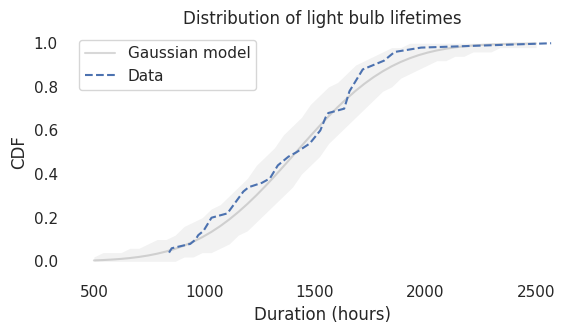

In [404]:
from empiricaldist import Cdf

qs = np.linspace(500, 2500)
ps = dist.cdf(qs)
plt.plot(qs, ps, color="gray", alpha=0.3, label="Gaussian model")

n = len(lifetimes)
low, high = normal_error_bounds(dist, n, qs)
plt.fill_between(qs, low, high, lw=0, color="gray", alpha=0.1)

surv = Cdf.from_seq(lifetimes)
surv.plot(ls="--", label="Data")
decorate(
    xlabel="Duration (hours)",
    ylabel="CDF",
    title="Distribution of light bulb lifetimes",
)

In [405]:
from scipy.stats import gaussian_kde

xs = np.linspace(0, 3000, 201)
ys = gaussian_kde(lifetimes).evaluate(xs)
density = Pmf(ys, xs, name='')
density.normalize()

0.06666298081917303

In [406]:
mean = lifetimes.mean()
mean

1413.84

In [407]:
def decorate_kde(title=''):
    decorate(
        xlabel="Duration (hours)",
        ylabel="Density",
        xlim=[0, 3000],
        yticks=[],
        title=title
    )

In [408]:
def plot_density(density):
    mean = density.mean()
    density.plot()
    plt.axvline(mean, ls=':')
    # plt.text(mean-20, 0.002, f'mean  {mean:0.0f}', ha='center')
    decorate_kde()

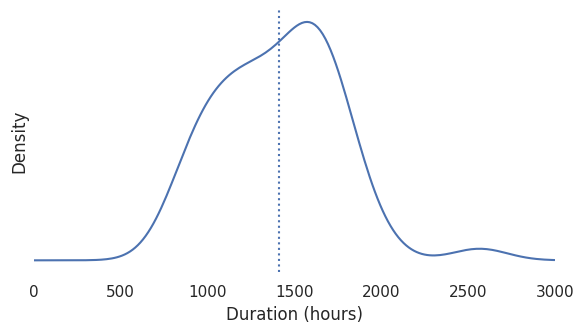

In [409]:
plot_density(density)
savefig('nbue1a.png')

In [410]:
def plot_conditional(density, age):
    left = density[density.qs < age]
    right = density[density.qs >= age]

    left.plot()
    right.plot(color='C0')

    plt.fill_between(right.index, 0, right.values, alpha=0.1)
    decorate_kde()
    return right

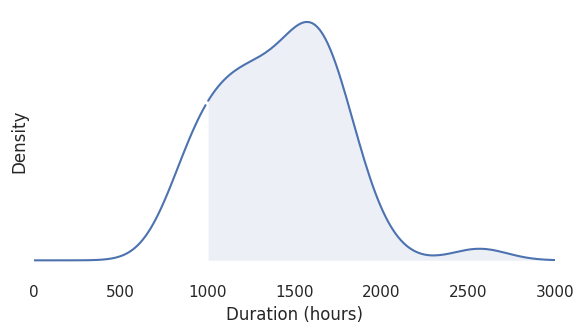

In [411]:
age = 1000
conditional = plot_conditional(density, age)
savefig('nbue1b.png')

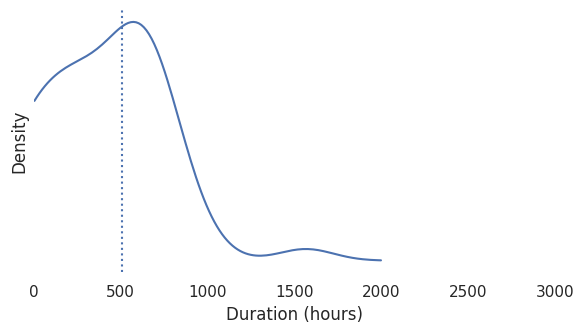

In [412]:
shifted = Pmf(conditional.values, conditional.index - age)
shifted.normalize()
plot_density(shifted)
savefig('nbue1c.png')

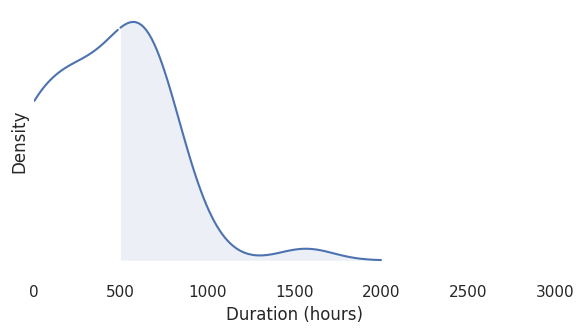

In [413]:
age = 500
conditional = plot_conditional(shifted, age)
savefig('nbue1d.png')

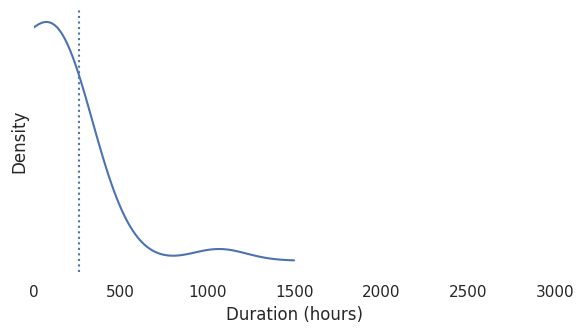

In [414]:
shifted = Pmf(conditional.values, conditional.index - age)
shifted.normalize()
plot_density(shifted)
savefig('nbue1e.png')

The shaded area shows how much variation we expect from the Gaussian model.
Except for one unusually long-lasting bulb, the lifetimes fall within the bounds, which shows that the data are consistent with the model.

In this dataset, the average lifetime for a new light bulb is about 1414 hours.
For a bulb that has been used for 1000 hours, the average lifetime is higher, about 1495 hours; however, since it has already burned 1000 hours, its average remaining lifetime is only 495 hours.
So we would rather have the new bulb.

In [415]:
np.mean(lifetimes)

1413.84

In [416]:
lifetimes[lifetimes > 1000].mean() - 1000

495.2558139534883

In [417]:
lifetimes[lifetimes > 1500].mean() - 1500

213.391304347826

We can do the same calculation for a range of elapsed times from 0 to 2568 hours (the lifespan of the oldest bulb).
At each point in time, $t$, we can compute the average lifetime for bulbs that survive past $t$ and the average remaining lifetime we expect.

In [418]:
def remaining_lifetimes_seq(seq, qs=None):
    """Compute average remaining lifetimes.
    
    seq: sequence of quantities
    qs: ages to evaluate
    
    returns: Series
    """
    if qs is None:
        qs = np.linspace(0, seq.max(), 200)        

    series = pd.Series(index=qs, dtype=float)
    for q in qs:
        conditional = Pmf.from_seq(seq[seq >= q])
        if conditional.sum() > 0:
            conditional.normalize()
            series[q] = conditional.mean() - q

    return series.dropna()

To compute error bounds, we'll use resampling.

In [419]:
def resample(xs):
    """Resample a sequence of quantities.
    
    xs: quantities
    
    returns: sample
    """
    return np.random.choice(xs, size=len(xs), replace=True)

In [420]:
mu, sigma = lifetimes.mean(), lifetimes.std()
dist = norm(mu, sigma)

n = len(lifetimes)
qs = pmf_lifetimes.index

The following loop generates multiple resamplings and compute the remaining lifetimes for each.

In [421]:
np.random.seed(17)
from scipy.stats import gaussian_kde

kde = gaussian_kde(lifetimes)

res = []
qs = np.arange(0, 2550, 50)
for i in range(201):
    sample = kde.resample(len(lifetimes))
    rem = remaining_lifetimes_seq(sample, qs)
    res.append(rem)

In [422]:
x = 1000
y = lifetimes[lifetimes > 1000].mean() - x
x, y

(1000, 495.2558139534883)

The following two functions compile the results and compute error bounds.

In [423]:
def percentile_rows(series_seq, ps):
    """Computes percentiles from aligned series.

    series_seq: list of sequences
    ps: cumulative probabilities

    returns: Series of x-values, NumPy array with selected rows
    """
    # NOTE: This is a specialized version of this function that
    # fills NaNs with 0
    df = pd.concat(series_seq, axis=1).fillna(0)
    xs = df.index
    array = df.values.transpose()
    array = np.sort(array, axis=0)
    nrows, ncols = array.shape

    ps = np.asarray(ps)
    indices = (ps * nrows).astype(int)
    rows = array[indices]
    return xs, rows

In [424]:
def plot_percentiles(series_seq, label=None, **options):
    """Plot the low, median, and high percentiles.
    
    series_seq: sequence of Series
    ps: percentiles to use for low, medium and high
    label: string label for the median line
    options: options passed plt.plot and plt.fill_between
    """
    ps = [0.05, 0.5, 0.95]
    xs, rows = percentile_rows(series_seq, ps)
    low, med, high = rows
    plt.plot(xs, med, alpha=0.5, label=label, **options)
    plt.fill_between(xs, low, high, linewidth=0, alpha=0.2, **options)

In [430]:
ps = [0.5]
xs, rows = percentile_rows(res, ps)
(med,) = rows

x = 1000
y = pd.Series(med, xs)[x]

The following figure shows the result.

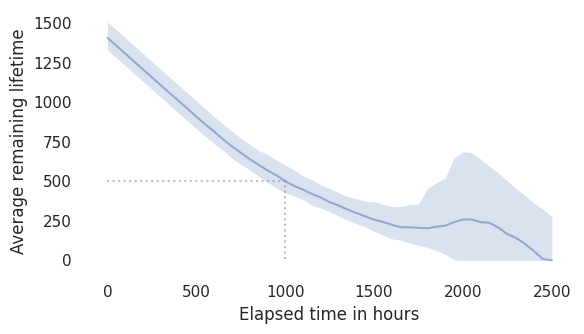

In [431]:
plt.plot([0, x, x], [y, y, 0], ":", color="gray", alpha=0.5)
plot_percentiles(res, color="C0")

decorate(
    xlabel="Elapsed time in hours",
    ylabel="Average remaining lifetime",
    # title="Average remaining lifetime of light bulbs",
)
savefig('nbue2.png')

The x-axis shows elapsed times since the installation of a hypothetical light bulb.
The y-axis shows the average remaining lifetime.
In this example, a bulb that has been burning for 1000 hours is expected to last about 495 hours more, as indicated by the dotted lines.

So a new bulb generally lasts longer than a used bulb.

In [427]:
(lifetimes > 1450).sum(), (lifetimes > 1710).sum(), (lifetimes > 1800).sum()

(25, 11, 5)

## Any day now

Now let's consider the question posed by the imaginary obstetrician at lunch.
Suppose you visit a maternity ward and meet women who are starting their 39th, 40th, and 41st week of pregnancy.
Which one do you think will deliver first?

To answer this question, we need to know the distribution of gestation times, which we can get from the National Survey of Family Growth (NSFG), which was the source of the birth weights in Chapter~\ref{extremes-outliers-and-goats}.
I gathered data collected between 2002 and 2017, which includes information about 43,939 live births.

I've made a subset of the data available in an HDF file.

In [432]:
download(DATA_PATH + "nsfg.hdf5")

In [433]:
# data cleaning is in FirstLateNSFG repo
# includes data from 2002, 2006-2010, 2011-2013, 2013-2015,  2015-2017

nsfg = pd.read_hdf("nsfg.hdf5", "nsfg")
nsfg.shape

(62539, 7)

In [434]:
nsfg.head()

,pregend1,nbrnaliv,prglngth,outcome,birthord,finalwgt,cycle
0,6.0,1.0,40,1,1.0,19877.457610,10
1,1.0,NaN,14,4,NaN,19877.457610,10
2,6.0,1.0,39,1,2.0,19877.457610,10
3,6.0,1.0,39,1,1.0,4221.017695,10
4,6.0,1.0,39,1,2.0,4221.017695,10


I selected live births with pregnancy lengths less than 45 weeks (the outliers are probably errors).

In [435]:
live = nsfg["outcome"] == 1
reasonable = nsfg["prglngth"] < 45

lengths = nsfg.loc[live & reasonable, "prglngth"]
pmf_length = Pmf.from_seq(lengths)
len(lengths)

43246

In [436]:
(lengths < 28).mean() * 100

0.9272533875965407

In [437]:
gt = pmf_length.qs >= 28
pmf_length_gt = Pmf(pmf_length[gt] * 100)

The following figure shows the distribution of their durations (except for the 1% of babies born prior to 28 weeks).

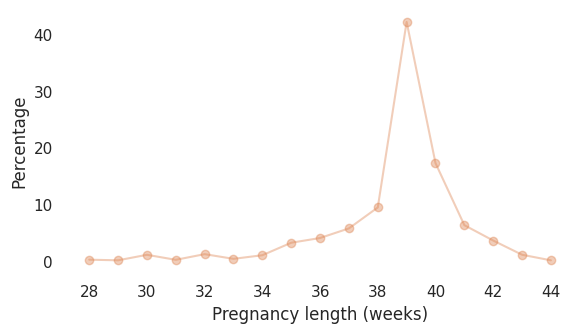

In [438]:
pmf_length_gt.plot(color="C1", marker="o", alpha=0.4, label='')

decorate(
    xlabel="Pregnancy length (weeks)",
    ylabel="Percentage",
    # title="Distribution of pregnancy length",
    xticks=np.arange(28, 46, 2),
)
savefig('nbue3.png')

About 41% of these births were during the 39th week of pregnancy, and another 18% during the 40th week.

In [439]:
lengths.mean(), pmf_length_gt[39], pmf_length_gt[40]

(38.505341534477175, 42.357674698237986, 17.400453221107153)

I'll use resampling to compute error bounds. Since the sampling weights are specific to each cycle, I'll do the resampling within the cycles.

In [440]:
for name, group in nsfg.groupby("cycle"):
    print(name, len(group))

6 13593
7 20492
8 9543
9 9358
10 9553


In [441]:
def sample_by_cycle(df):
    sample = df.groupby("cycle").sample(frac=1, replace=True, weights="finalwgt")
    return sample

The following loop computes the remaining lifetimes for each resampling.

In [442]:
qs = np.arange(36, 44)
mrt_seq = []

for i in range(101):
    sample = sample_by_cycle(nsfg)

    live = sample["outcome"] == 1
    reasonable = sample["prglngth"] < 50

    lengths = sample.loc[live & reasonable, "prglngth"]
    mrt = remaining_lifetimes_seq(lengths, qs)

    mrt_seq.append(mrt)

In [443]:
def decorate_pregnancy(title=''):
    decorate(
        xlabel="Week of pregnancy",
        ylabel="Average remaining time",
        title=title,
        ylim=[0, 3.5],
    )

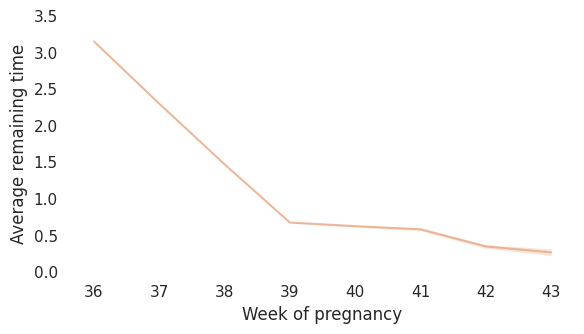

In [444]:
# the previous version of plot_percentiles was specialized;
# for this analysis we want the general one (not that it matters)
from utils import plot_percentiles

plot_percentiles(mrt_seq, color="C1")

#decorate_pregnancy(title="Average remaining duration of pregancy")
decorate_pregnancy(title="")
savefig('nbue4.png')

Between weeks 36 and 39, the curve behaves as we expect: as time goes on, we get closer to the finish line.
For example, at the beginning of week 36, the average remaining time is 3.2 weeks.
At the beginning of week 37, it is down to 2.3 weeks.
So far, so good: a week goes by and the finish line is just about one week closer.

But then, cruelly, the curve levels off.
At the beginning of week 39, the average remaining time is 0.68 weeks, so the end seems near.
But if we get to the beginning of week 40, and the baby has not been born, the average remaining time is 0.63 weeks.
A week has passed and the finish line is only 8 hours closer.

And if we get to the beginning of week 41, and the baby has not been born, the average remaining time is 0.59 weeks.
Another week has passed and the finish line is only 7 hours closer!

Here's the computation for the average remaining time at the end of each week.

In [134]:
from utils import percentile_rows

xs, ys = percentile_rows(mrt_seq, [0.025, 0.5, 0.975])
df = pd.DataFrame(np.transpose(ys), xs, columns=[2.5, 50, 97.5])
df

,2.5,50.0,97.5
36,3.142822,3.153736,3.165931
37,2.292390,2.303369,2.316928
38,1.465161,1.474933,1.488573
39,0.669659,0.679651,0.692118
40,0.612146,0.629809,0.647226
41,0.560671,0.586682,0.611351
42,0.320918,0.352373,0.382273
43,0.220000,0.271242,0.340611


In [135]:
df[50].diff().loc[[40, 41]] * 7 * 24

40   -8.373551
41   -7.245228
Name: 50.0, dtype: float64

39 4.757559429477013
39.679651347068145 4.520430465974382
40.32542712792163 4.310420075240543
40.941201424384566 4.124527367596406
41.530419619755484 3.2367992226202267
41.99281950870123 2.4783853029123057


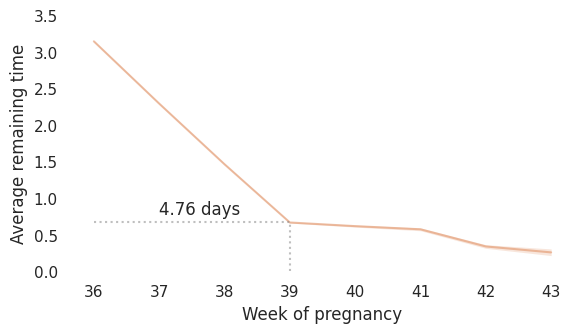

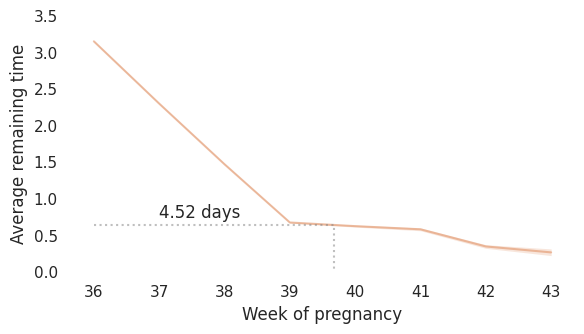

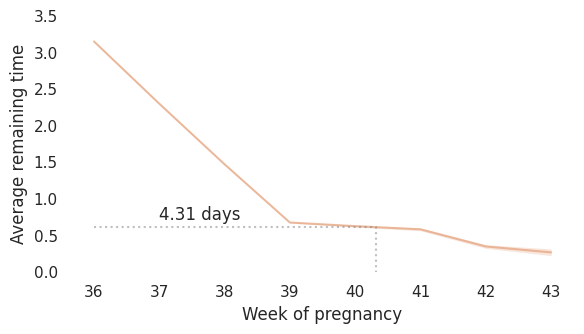

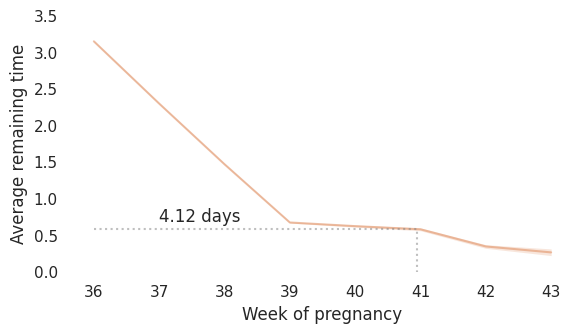

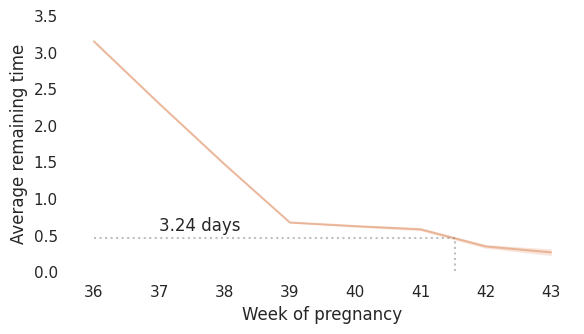

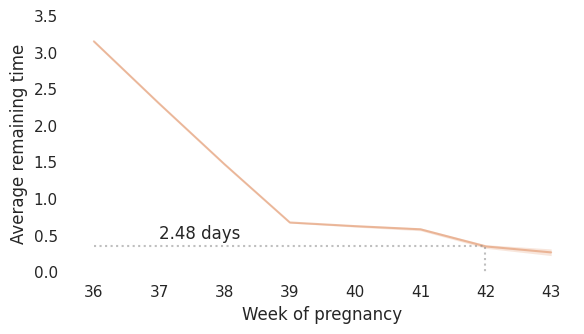

In [145]:
from scipy.interpolate import interp1d
from empiricaldist import Hazard

series = df[50]
interp = interp1d(series.index, series.values, fill_value="extrapolate")

x = 39

for letter in 'abcdef':
    y = interp(x)
    print(x, y*7)
    plt.figure()
    plot_percentiles(mrt_seq, color="C1")
    plt.plot([36, x, x], [y, y, 0], ":", color="gray", alpha=0.5)
    plt.text(37, y+0.1, f'{y*7:0.2f} days')
    decorate_pregnancy(title='')
    savefig(f'nbue4{letter}.png')
    x += y

## Cancer survival times

Finally, let's consider the surprising result reported by the imaginary oncologist at lunch: for many cancers, a patient who has survived a year after diagnosis is expected to live longer than someone who has just been diagnosed.

To demonstrate and explain this result, I'll use data from the the Surveillance, Epidemiology, and End Results (SEER) program, which is run by the U.S. National Institutes of Health (NIH).
Starting in 1973, SEER has collected data on cancer cases from registries in several locations in the United States.
In the most recent datasets, these registries cover about one third of the U.S. population.

NOTE: I am definitely not allowed to redistribute SEER data, so the data in this example in synthetic; that is, I have generated random data that is statistically similar to the actual data I reported in the book. The results below will differ from what's in the book, but the conclusions are qualitatively similar.

In [149]:
filename = "brain.hdf"
download(DATA_PATH + filename)

In [150]:
brain = pd.read_hdf("brain.hdf", "brain")
brain.shape

(16202, 2)

In [151]:
brain.head()

,duration,observed
0,4.50,True
1,15.75,True
2,10.75,True
3,6.25,True
4,29.50,True


From the SEER data I selected the 16,202 cases of glioblastoma, diagnosed between 2000 and 2016, where the survival times are available.
We can use this data to infer the distribution of survival times, but first we have to deal with a statistical obstacle: some of the patients are still alive, or were alive the last time they appeared in a registry.

For these cases, the time until their death is unknown, which is a good thing.
However, in order to work with data like this, we need a special method, called Kaplan-Meier estimation, to compute the distribution of lifetimes.

`duration` is the observed duration in months, for both complete and ongoing cases.

In [152]:
duration = brain["duration"]
duration.describe()

count    16202.000000
mean        13.457783
std         19.088951
min          0.250000
25%          3.250000
50%          7.750000
75%         16.500000
max        201.750000
Name: duration, dtype: float64

`observed` is a boolean that indicates whether each case is complete or ongoing.

In [153]:
observed = brain["observed"]
observed.sum()

14548

In [154]:
(duration[observed] == 0).mean(), (duration[~observed] == 0).mean()

(0.0, 0.0)

As we should expect, the distributions are different for the complete and ongoing cases.

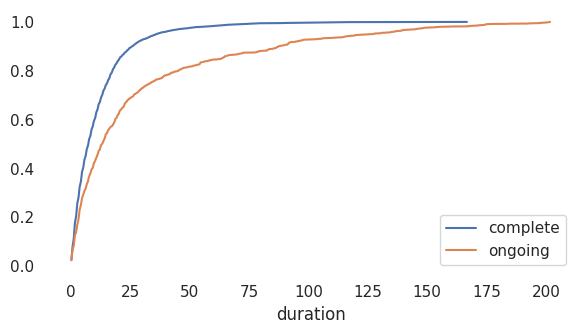

In [155]:
Cdf.from_seq(duration[observed]).plot(label="complete")
Cdf.from_seq(duration[~observed]).plot(label="ongoing")

decorate(xscale="linear")

With Kaplan-Meier estimation, we can use all cases to estimate the survival function.

In [156]:
import lifelines
from empiricaldist import Surv


def km_fit(duration, observed):
    """Compute a survival function by Kaplan-Meier estimation.
    
    duration: sequence of durations for complete and incomplete cases
    observed: sequence booleans indicating whether each case is complete
    
    returns: tuple of Surv (estimate, low, high)
    """
    fit = lifelines.KaplanMeierFitter().fit(duration, observed)
    surv_km = Surv(fit.survival_function_["KM_estimate"])

    ci_fit = fit.confidence_interval_
    surv_low = Surv(ci_fit["KM_estimate_lower_0.95"])
    surv_high = Surv(ci_fit["KM_estimate_upper_0.95"])

    return surv_km, surv_low, surv_high

In [157]:
surv_km, surv_low, surv_high = km_fit(duration, observed)
surv_km.head()

,probs
timeline,
0.00,1.00000
0.25,0.97667
0.50,0.95130


In [158]:
def plot_fit(surv_km, surv_low, surv_high, **options):
    """Plot an estimated survival curve with error bounds.
    
    surv_km: estimated Surv
    surv_low, surv_high: lower and upper bounds
    options: passed to Series.plot
    """
    xs = surv_low.index
    plt.fill_between(xs, surv_low, surv_high, color="gray", alpha=0.3)
    surv_km.plot(**options)

The following figure shows the result on a log scale, plotted in the familiar form of a CDF and in a new form called a survival curve.

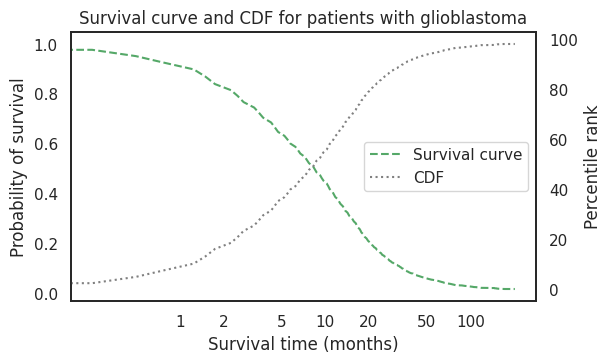

In [159]:
ax1 = plt.gca()
surv_km.plot(ls="--", color='C2', label="Survival curve")
h1, l1 = plt.gca().get_legend_handles_labels()
plt.ylabel("Probability of survival")
plt.xlabel("Survival time (months)")

plt.xscale("log")
labels = [1, 2, 5, 10, 20, 50, 100]
ticks = labels
plt.xticks(ticks, labels)

ax2 = plt.twinx()
ax1.tick_params(left=False, right=False)

cdf = surv_km.make_cdf() * 100
cdf.plot(color="gray", ls=":", label="CDF")
h2, l2 = plt.gca().get_legend_handles_labels()
plt.legend(h1 + h2, l1 + l2, loc="center right")
plt.ylabel("Percentile rank")

plt.title("Survival curve and CDF for patients with glioblastoma")
ax2.tick_params(left=False, right=False)
savefig('nbue5.png')

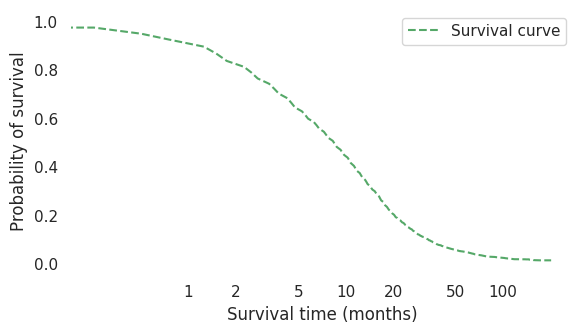

In [163]:
surv_km.plot(ls="--", color='C2', label="Survival curve")

plt.xscale("log")
labels = [1, 2, 5, 10, 20, 50, 100]
ticks = labels
plt.xticks(ticks, labels);

decorate(ylabel="Probability of survival",
         xlabel="Survival time (months)")

savefig('nbue5a.png')

The survival curve shows the probability of survival past a given time on a scale from 0 to 1.
It is the complement of the CDF, so as the CDF increases from left to right, the survival curve decreases.
The two curves contain the same information; the only reason to use one or the other is convention.
Survival curves are used more often in medicine and reliability engineering, CDFs in many other fields.

One thing that is apparent -- from either curve -- is that glioblastoma is a serious diagnosis.
The median survival time after diagnosis is less than 9 months, and only about 16% of patients survive more than two years.

Please keep in mind that this curve lumps together people of different ages with different health conditions, diagnosed at different stages of disease over a period of about 16 years.
Survival times depend on all of these factors, so this curve does not provide a prognosis for any specific patient.
In particular, as treatment has gradually improved, the prognosis is better for someone with a more recent diagnosis.
If you or someone you know is diagnosed with glioblastoma, you should get a prognosis from a doctor, based on specifics of the case, not from aggregated data in a book demonstrating basic statistical methods.

In [167]:
surv_km(12), surv_km(24), surv_km(24)/surv_km(12)

(array(0.38549537), array(0.16368232), 0.42460256589027323)

As we did with light bulbs and pregnancy lengths, we can use this distribution to compute the average remaining survival time for patients at each time after diagnosis.
The following figure shows the result.

In [168]:
from utils import remaining_lifetimes_pmf

np.random.seed(17)
qs = np.linspace(0, 165, 101)
rem_seq = []

for i in range(101):
    sample = brain.sample(frac=1, replace=True)
    observed = sample["observed"]
    duration = sample["duration"]
    surv_km, surv_high, surv_low = km_fit(duration, observed)
    rem = remaining_lifetimes_pmf(surv_km.make_pmf(), qs)
    # rem.plot(color="gray", alpha=0.01)
    rem_seq.append(rem)

In [180]:
def gray_box(x, x_max=170):
    """Make a gray box that spans the y-axis.

    x_max: location of the right bound
    """
    plt.axvspan(x, x_max, facecolor="gray", edgecolor='none', alpha=0.1)
    plt.xlim([-5, x_max])

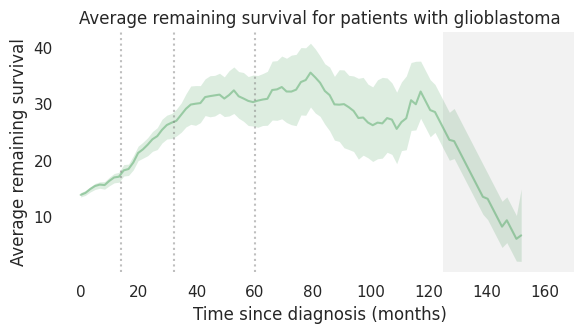

In [182]:
plot_percentiles(rem_seq, color='C2')
gray_box(125)
for x in [14, 32, 60]:
    plt.axvline(x, color="gray", ls=":", alpha=0.5)

decorate(
    xlabel="Time since diagnosis (months)",
    ylabel="Average remaining survival",
    title="Average remaining survival for patients with glioblastoma",
)
savefig('nbue6.png')

In [183]:
qs = np.arange(0, 165)
series = remaining_lifetimes_pmf(surv_km.make_pmf(), qs)
milestones = series[[0, 14, 32, 60]]
milestones

0     13.773990
14    17.069424
32    24.735119
60    27.839032
dtype: float64

In [ ]:
ps = [0.05, 0.5, 0.95]
xs, rows = percentile_rows(rem_seq, ps)
low, med, high = rows

13.773989705091937
13.773989705091937
30.843413403818417
13.773989705091937
30.843413403818417
55.578532081470954
13.773989705091937
30.843413403818417
55.578532081470954
83.41756386272576


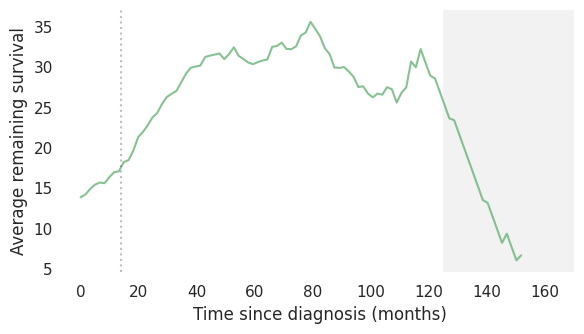

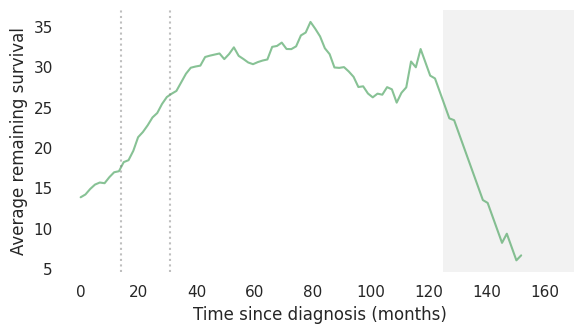

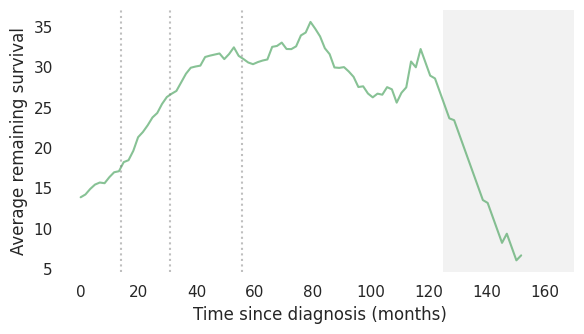

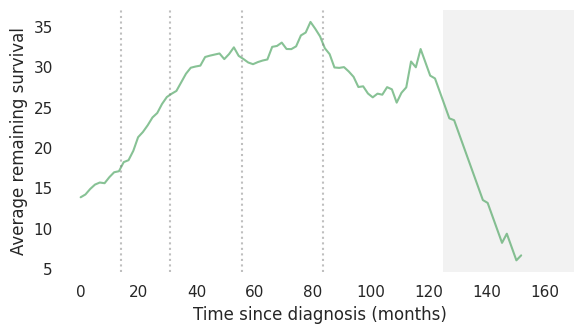

In [189]:
for i, letter in enumerate('abcd'):
    plt.figure()
    plt.plot(xs, med, alpha=0.7, label='', color='C2')
    gray_box(125)
    for x in milestones.cumsum()[:i+1]:
        print(x)
        plt.axvline(x, color="gray", ls=":", alpha=0.5)

    decorate(
        xlabel="Time since diagnosis (months)",
        ylabel="Average remaining survival",
    )
    savefig(f'nbue6{letter}.png')

At the time of diagnosis, the average survival time is about 14 months.
That is certainly a bleak prognosis, but there is some good news to follow.
If a patient survives the first 14 months, we expect them to survive another 18 months, on average.
If they survive those 18 months, for a total of 32, we expect them to survive another 28 months.
And if they survive those 28 months, for a total of 60 months (five years), we expect them to survive another 35 months (almost three years).
The vertical lines indicate these milestones.
It's like running a race where the finish line keeps moving, and the farther you go, the faster it retreats.

If you hear that the average survival time after diagnosis is 14 months, you might imagine a Gaussian distribution where 14 months is the most common value and an equal number of patients live more or less than 14 months.
But that would be a very misleading picture.

To show how bad it would be, I chose a Gaussian distribution that matches the distribution of survival times as well as possible -- which is not very well -- and used it to compute average remaining survival times.

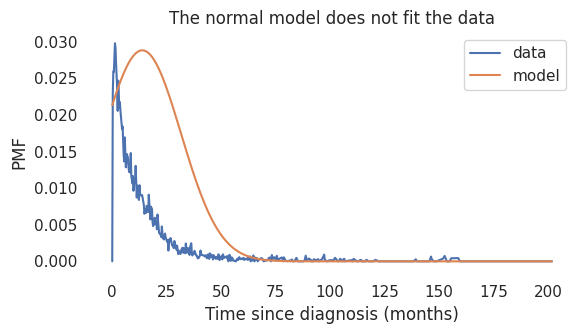

In [172]:
from utils import make_normal_model

pmf_km = surv_km.make_pmf()
pmf_normal = make_normal_model(pmf_km)

pmf_km.plot(label='data')
pmf_normal.plot(label='model')
decorate(
    xlabel="Time since diagnosis (months)",
    ylabel="PMF",
    title="The normal model does not fit the data",
)

In [57]:
series = remaining_lifetimes_pmf(pmf_normal)
series.tail()

197.694724    0.972382
198.708543    0.829894
199.722362    0.630459
200.736181    0.358620
201.750000    0.000000
dtype: float64

As a result, the remaining lifetimes from the model don't resemble the remaining lifetimes from the data.

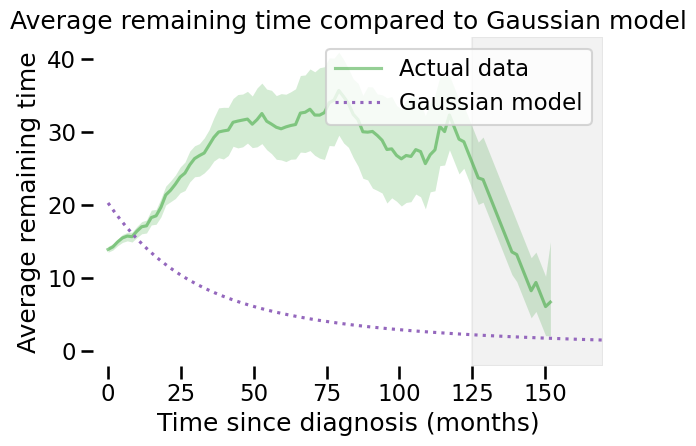

In [58]:
plot_percentiles(rem_seq, color='C2', label="Actual data")
series.plot(color="C4", ls=":", label="Gaussian model")

gray_box(125)
decorate(
    xlabel="Time since diagnosis (months)",
    ylabel="Average remaining time",
    title="Average remaining time compared to Gaussian model",
    loc="upper right",
)

With the Gaussian model, the average remaining survival time starts around 20 months,
drops quickly at first, and levels off around 5 months.
So it behaves nothing like the actual averages.

On the other hand, if your mental model of the distribution is lognormal, you would get it about right.
To demonstrate, I chose a lognormal distribution that fits the actual distribution of survival times and used it to compute average remaining lifetimes.

Here's the function that fits the distribution.

In [59]:
from scipy.optimize import least_squares


def fit_lognormal(surv, xs=None):
    """Fit a lognormal distribution to a survival function.
    
    surv: Surv object
    xs: places to evaluate the survival function
    
    returns: Surv
    """
    def error_func(params):
        mu, sigma = params
        # just fit over the range from 0 to 120 months
        xs = np.logspace(0, np.log10(120))

        ps = norm.sf(np.log(xs), mu, sigma)
        error = ps - surv_km(xs)
        return error

    pmf = surv.make_pmf()
    pmf.normalize()
    params = pmf.mean(), pmf.std()
    res = least_squares(error_func, x0=params, xtol=1e-3)
    assert res.success
    mu, sigma = res.x

    xs = surv.index if xs is None else xs
    ps = norm.sf(np.log(xs), mu, sigma)
    return Surv(ps, xs)

In [60]:
surv_lognormal = fit_lognormal(surv_km)
pmf_lognormal = surv_lognormal.make_pmf()

In [61]:
series = remaining_lifetimes_pmf(pmf_lognormal)

The following figure shows the result.

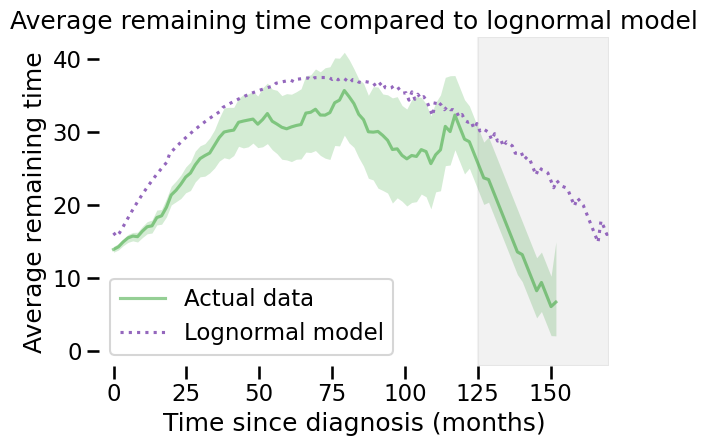

In [62]:
plot_percentiles(rem_seq, color='C2', label="Actual data")
series.plot(color="C4", ls=":", label="Lognormal model")
gray_box(125)

decorate(
    xlabel="Time since diagnosis (months)",
    ylabel="Average remaining time",
    title="Average remaining time compared to lognormal model",
)
plt.legend(loc="lower left")
None

During the first 24 months, the model is a little too optimistic, and after 120 months it is much too optimistic.
But the lognormal model gets the shape of the curve right: if your mental model of the distribution is lognormal, you would have a reasonably accurate understanding of the situation.

## Life Expectancy At Birth

In 2012, a team of demographers at the University of Southern California estimated life expectancy for people born in Sweden in the early 1800s and 1900s.
They chose Sweden because it "has the deepest historical record of high-quality [demographic] data."

For ages from 0 to 91 years, they estimated the mortality rate, which is the fraction of people at each age who die.

I used an online graph digitizer to get the data from the figure in their paper and store it in a CSV file.

In [195]:
filename = "mortality_rates_beltran2012.csv"
download(DATA_PATH + filename)

In [196]:
mortality = pd.read_csv(filename, header=[0, 1])
mortality.head()

1905                1800          
          X         Y         X         Y
0  0.056633 -2.685744  0.066515 -1.541222
1  0.175223 -2.866213  0.224635 -1.692583
2  0.293812 -3.043189  0.362990 -1.890516
3  0.412402 -3.216672  0.481580 -2.052938
4  0.530992 -3.390155  0.623887 -2.239811

In [197]:
def make_series(x, y):
    """Make a pandas Series.
    
    x: values for the index
    y: values of the series
    
    returns: Series
    """
    return pd.Series(y, x).dropna()

In [198]:
mort1800 = make_series(mortality["1800", "X"], mortality["1800", "Y"].values)
mort1800.head()

(1800, X)
0.066515   -1.541222
0.224635   -1.692583
0.362990   -1.890516
0.481580   -2.052938
0.623887   -2.239811
dtype: float64

In [199]:
mort1905 = make_series(mortality["1905", "X"], mortality["1905", "Y"].values)
mort1905.head()

(1905, X)
0.056633   -2.685744
0.175223   -2.866213
0.293812   -3.043189
0.412402   -3.216672
0.530992   -3.390155
dtype: float64

In [200]:
np.exp(mort1800.iloc[0]), np.exp(mort1905.iloc[0])

(0.21411938757305218, 0.06817045483264002)

The following function interpolates the data from the figure and puts it in a Hazard function.

In [201]:
from scipy.interpolate import interp1d
from empiricaldist import Hazard


def make_hazard(series):
    """Make a Hazard function by interpolating a Series.
    
    series: Series
    
    returns: Hazard
    """
    interp = interp1d(series.index, series.values, fill_value="extrapolate")
    xs = np.arange(0, 108)
    ys = np.exp(interp(xs))
    return Hazard(ys, xs)

In [202]:
haz1800 = make_hazard(mort1800)
haz1905 = make_hazard(mort1905)


The following figure shows the results for two cohorts: people born between 1800 and 1810, and people born between 1905 and 1915.

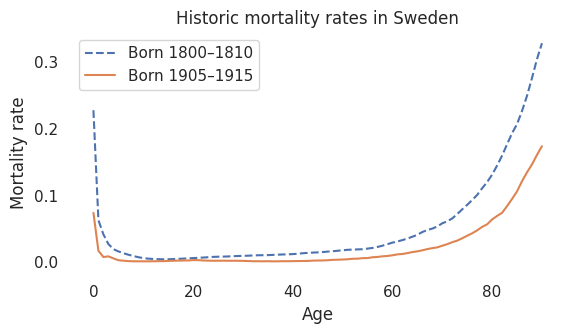

In [217]:
haz1800[:91].plot(label="Born 1800–1810", ls="--")
haz1905[:91].plot(label="Born 1905–1915")

decorate(
    xlabel="Age", ylabel="Mortality rate", title="Historic mortality rates in Sweden"
)
savefig('nbue7.png')

The notable feature is that mortality rates were lower for the later cohort at every age.

In [218]:
haz1800[0], haz1905[0]

(0.2281961996457684, 0.07430619990025686)

In [219]:
haz1800.min(), haz1800.idxmin(), haz1905[14]

(0.004624153294009557, 14, 0.0019040788545011136)

In [220]:
haz1800[80], haz1905[80]

(0.13156208289057392, 0.06441158462898641)

In [221]:
pmf1800 = haz1800.make_pmf()
pmf1800.normalize()

0.9999999998644409

In [222]:
pmf1905 = haz1905.make_pmf()
pmf1905.normalize()

0.9999711879585407

In [223]:
pmf1800.mean(), pmf1905.mean()

(36.473535530889244, 65.67277539967878)

The following figure shows life expectancy as a function of age for people born in Sweden around 1800 and 1905.

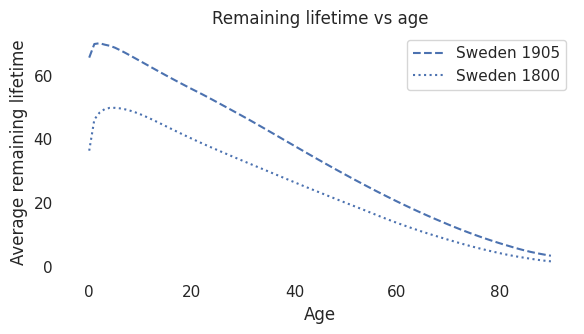

In [227]:
qs = np.arange(0, 91)
series1905 = remaining_lifetimes_pmf(pmf1905, qs)
series1905.plot(ls="--", color="C0", label="Sweden 1905")

series1800 = remaining_lifetimes_pmf(pmf1800, qs)
series1800.plot(ls=":", color="C0", label="Sweden 1800")

decorate(
    xlabel="Age", ylabel="Average remaining lifetime", title="Remaining lifetime vs age"
)
savefig('nbue8a.png')

In [228]:
def draw_lines(pmf, series):
    x = pmf.mean()
    y = series[int(round(x))]
    plt.plot([0, x, x], [y, y, 0], ":", color="gray", alpha=0.5)

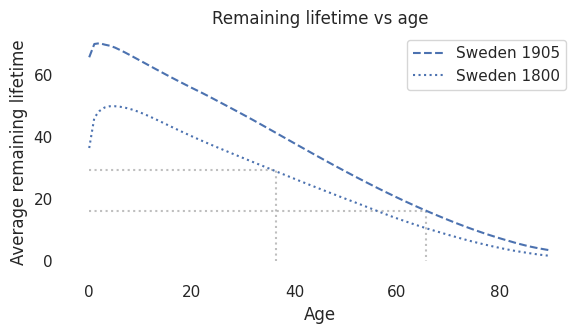

In [229]:
qs = np.arange(0, 91)
series1905 = remaining_lifetimes_pmf(pmf1905, qs)
draw_lines(pmf1905, series1905)
series1905.plot(ls="--", color="C0", label="Sweden 1905")

series1800 = remaining_lifetimes_pmf(pmf1800, qs)
draw_lines(pmf1800, series1800)
series1800.plot(ls=":", color="C0", label="Sweden 1800")

decorate(
    xlabel="Age", ylabel="Average remaining lifetime", title="Remaining lifetime vs age"
)
savefig('nbue8b.png')

In both cohorts, used was better than new, at least for the first few years of life.

In [230]:
series1800[0], series1800.idxmax(), series1800.max()

(36.473535530889244, 5, 49.9171982587444)

In [231]:
series1905[0], series1905.idxmax(), series1905.max()

(65.67277539967881, 2, 70.18860681489375)

In [232]:
series1800[0], series1800[36], series1800[65]

(36.473535530889244, 29.241600197695945, 11.018435234417836)

In [233]:
series1905[5]

68.80456362586426

In [234]:
series1905[0], series1905[66], series1905[82]

(65.67277539967881, 16.058634133594552, 6.471530454841982)

## Child mortality

The following figure shows the percentage of children who die before age 5 for four geographical regions, from 1900 to 2019.
These data were combined from several sources by Gapminder, a foundation based in Sweden that "promotes sustainable global development [...] by increased use and understanding of statistics."

Documentation of the data is at <https://www.gapminder.org/data/documentation/gd005>

The data is in [this online spreadsheet](https://docs.google.com/spreadsheets/d/1Av7eps_zEK73-AdbFYEmtTrwFKlfruBYXdrnXAOFVpM/edit#gid=501532268), which I downloaded in August 2022.

In [235]:
filename = "GM-ChildMortality-Dataset-v11.xlsx"
download(DATA_PATH + filename)

In [236]:
gm = pd.read_excel(filename, sheet_name="data-for-regions-by-year")
gm.tail()

,geo,name,time,Child mortality
1199,americas,The Americas,2096,2.70
1200,americas,The Americas,2097,2.67
1201,americas,The Americas,2098,2.63
1202,americas,The Americas,2099,2.60
1203,americas,The Americas,2100,2.59


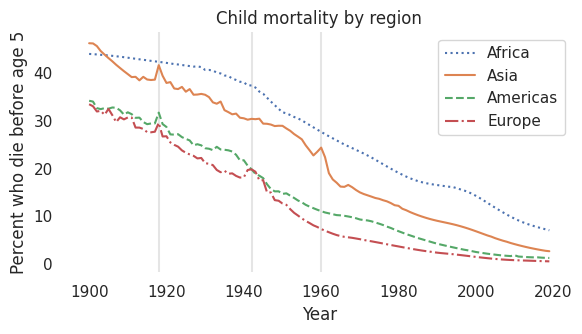

In [237]:
grouped = gm.groupby("geo")
line_styles = {"africa": ":", "asia": "-", "americas": "--", "europe": "-."}

for x in [1918, 1942, 1960]:
    plt.axvline(x, color="gray", alpha=0.2)

for name in ["africa", "asia", "americas", "europe"]:
    group = grouped.get_group(name)
    series = pd.Series(group["Child mortality"].values / 10, group["time"])
    series.loc[1900:2019].plot(label=name.title(), ls=line_styles[name])

decorate(
    xlabel="Year",
    ylabel="Percent who die before age 5",
    title="Child mortality by region",
)

In every region, child mortality has decreased consistently and substantially.

I collected recent mortality data from the [Global Health Observatory](https://apps.who.int/gho/data/node.main.LIFECOUNTRY?lang=en) of the World Health Organization (WHO).
For people born in 2019, we don't know what their future lifetimes will be, but we can estimate it if we assume that the mortality rate in each age group will not change over their lifetimes.

In [238]:
def read_hazard(filename):
    """Read age-specific death rates and make a Hazard object.

    filename: string

    returns: Hazard
    """
    df = pd.read_csv(filename, header=[1])

    query = 'Indicator == "nMx - age-specific death rate between ages x and x+n"'
    nmx = df.query(query)

    index = nmx["Age Group"].values
    ages = np.arange(-5, 90, 5)
    age_series = pd.Series(ages, index)
    age_series.iloc[[0, 1]] = [0, 1]

    rate = nmx["Both sexes"]
    rate.index = age_series.values
    hazard = rate.reindex(np.arange(111)).ffill()
    return Hazard(hazard)

In [239]:
download(DATA_PATH + "life_table_sweden_2019.csv")
download(DATA_PATH + "life_table_nigeria_2019.csv")

In [240]:
filename = "life_table_sweden_2019.csv"
hazard = read_hazard(filename)

pmf_swe = hazard.make_pmf()
pmf_swe.normalize()
pmf_swe.mean()

81.6599453119953

In [241]:
filename = "../data/life_table_nigeria_2019.csv"
hazard = read_hazard(filename)
hazard.head()

,probs
0,0.077958
1,0.011613
2,0.011613


In [242]:
pmf_nga = hazard.make_pmf()
pmf_nga.normalize()
pmf_nga.mean()

61.59620754538476

Based on that simplification, the following figure shows average remaining lifetime as a function of age for Sweden and Nigeria in 2019, compared to Sweden in 1905.

In [247]:
rem_swe = remaining_lifetimes_pmf(pmf_swe)
rem_nga = remaining_lifetimes_pmf(pmf_nga)
rem_swe[0]

81.6599453119953

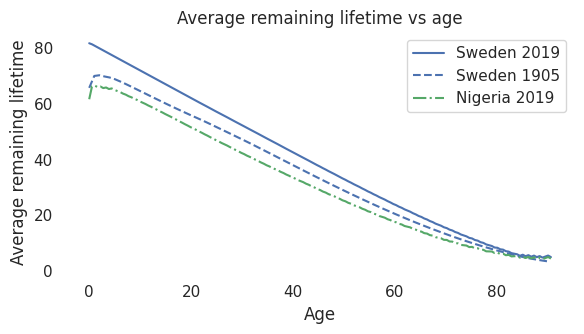

In [243]:
rem_swe.loc[:91].plot(label="Sweden 2019", ls="-")
series1905.plot(ls="--", color="C0", label="Sweden 1905")
rem_nga.loc[:91].plot(ls="-.", label="Nigeria 2019", color="C2")

decorate(
    xlabel="Age",
    ylabel="Average remaining lifetime",
    title="Average remaining lifetime vs age",
)

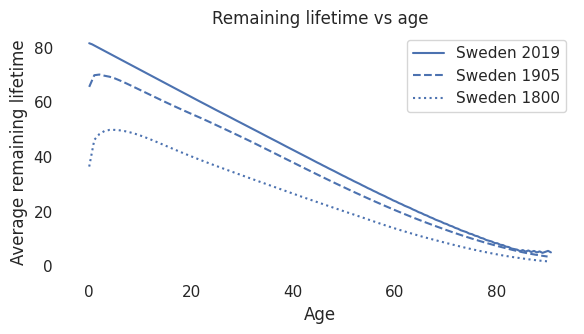

In [245]:
rem_swe.loc[:91].plot(label="Sweden 2019", ls="-")

series1905.plot(ls="--", color="C0", label="Sweden 1905")

series1800.plot(ls=":", color="C0", label="Sweden 1800")

decorate(
    xlabel="Age", ylabel="Average remaining lifetime", title="Remaining lifetime vs age"
)
savefig('nbue9.png')

In [94]:
rem_nga.head()

0.000000    61.596208
0.552764    66.256747
1.105528    66.478013
1.658291    65.925249
2.211055    66.143866
dtype: float64

## The Immortal Swede

Going back to the data from Sweden, the following figure shows the mortality rate for each age group, updated every ten years from 2000 to 2019.

In [250]:
download(DATA_PATH + "life_table_sweden.csv")

In [300]:
columns = ["Indicator", "Age Group", 2019, 2015, 2010, 2005, 2000]
df = pd.read_csv("life_table_sweden.csv", header=[1])
df.columns = columns
df.head()

,Indicator,Age Group,2019,2015,2010,2005,2000
0,nMx - age-specific death rate between ages x a...,<1 year,0.002042,0.002452,0.002579,0.002448,0.003451
1,nMx - age-specific death rate between ages x a...,1-4 years,0.000121,0.000127,0.000150,0.000211,0.000123
2,nMx - age-specific death rate between ages x a...,5-9 years,0.000061,0.000068,0.000063,0.000102,0.000097
3,nMx - age-specific death rate between ages x a...,10-14 years,0.000081,0.000110,0.000090,0.000101,0.000134
4,nMx - age-specific death rate between ages x a...,15-19 years,0.000217,0.000230,0.000271,0.000262,0.000355


In [301]:
index = df["Age Group"].values
ages = np.arange(-5, 90, 5)
age_series = pd.Series(ages, index)
age_series.iloc[[0, 1]] = [0, 1]
age_series

<1 year          0
1-4 years        1
5-9 years        5
10-14 years     10
15-19  years    15
20-24 years     20
25-29 years     25
30-34 years     30
35-39 years     35
40-44 years     40
45-49 years     45
50-54 years     50
55-59 years     55
60-64 years     60
65-69 years     65
70-74 years     70
75-79 years     75
80-84 years     80
85+ years       85
dtype: int64

In [302]:
df.drop(columns=["Indicator", "Age Group"], inplace=True)
df.index = age_series.values
df

,2019,2015,2010,2005,2000
0,0.002042,0.002452,0.002579,0.002448,0.003451
1,0.000121,0.000127,0.000150,0.000211,0.000123
5,0.000061,0.000068,0.000063,0.000102,0.000097
10,0.000081,0.000110,0.000090,0.000101,0.000134
15,0.000217,0.000230,0.000271,0.000262,0.000355
20,0.000407,0.000457,0.000458,0.000472,0.000511
25,0.000549,0.000575,0.000498,0.000500,0.000499
30,0.000598,0.000563,0.000505,0.000498,0.000524
35,0.000631,0.000604,0.000570,0.000710,0.000827
40,0.000836,0.000860,0.000916,0.001102,0.001240


In [339]:
from utils import Re70, Or70, Gr60, Bl50, Pu40


def plot_mortality(df):
    """Plot columns from a mortality DataFrame.
    
    df: DataFrame
    """
    df[2000].plot(lw=1, style="x-", color=Re70)
    # df[2005].plot(lw=1, ms=4, style="^--", color=Or70)
    df[2010].plot(lw=1, ms=4, style="s--", color=Gr60)
    # df[2015].plot(lw=1, ms=4, style="*--", color=Bl50)
    df[2019].plot(lw=1, ms=4, style="o-", color=Pu40)

    decorate(xlabel="Age", ylabel="Mortality rate", yscale="log")

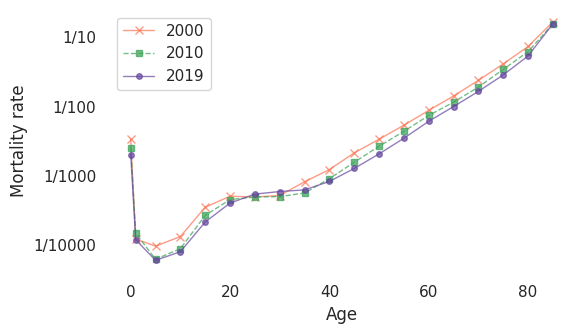

In [340]:
plot_mortality(df)
labels = ["1/10", "1/100", "1/1000", "1/10000"]
ticks = [1e-1, 1e-2, 1e-3, 1e-4]
plt.yticks(ticks, labels)
#decorate(title="Mortality rates in Sweden")
plt.tight_layout()
savefig('nbue10.png')

The straight-line increase after age 35 was described by Benjamin Gompertz in 1825, so this phenomenon is called the Gompertz Law.
It is an empirical law, which is to say that it names a pattern we see in nature, but at this point we don't have an explanation of why it's true, or whether it is certain to be true in the future.
Nevertheless, the data in this example fall in a remarkably straight line.

In [341]:
df.loc[[0, 50], 2019] * 100

0     0.204202
50    0.208688
Name: 2019, dtype: float64

In [342]:
df.loc[[10, 40, 65, 85], 2019] * 100

10     0.008100
40     0.083590
65     1.005406
85    15.695439
Name: 2019, dtype: float64

The previous figure also shows that mortality rates decreased between 2000 and 2019 in almost every age group.
If we zoom in on the age range from 40 to 80, we can see the changes in adult mortality more clearly.

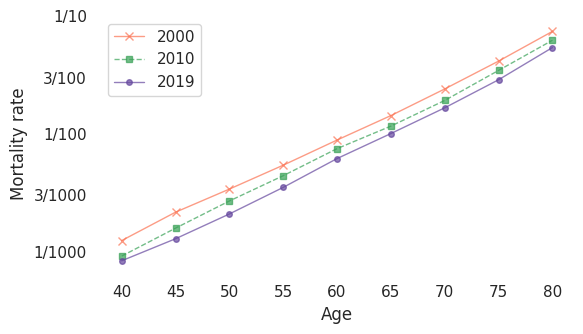

In [343]:
subset = df.loc[40:80]
plot_mortality(subset)


def add_yticks():
    labels = ["1/10", "3/100", "1/100", "3/1000", "1/1000"]
    ticks = [1e-1, 3e-2, 1e-2, 3e-3, 1e-3]
    plt.yticks(ticks, labels)


add_yticks()
#decorate(title="Mortality rates for adults in Sweden")
plt.tight_layout()
savefig('nbue11.png')

In these age groups, the decreases in mortality have been remarkably consistent.
By fitting a model to this data, we can estimate the rate of change as a function of both age and time.
According to the model, as you move from one age group to the next, your mortality rate increases by about 11% per year.
At the same time, for the reasons I just mentioned, the mortality rate in every age group decreases by about 2% per year.

In [344]:
data = subset.stack().reset_index()
data.columns = ["age", "year", "rate"]
data["log_rate"] = np.log10(data["rate"])
data.head()

,age,year,rate,log_rate
0,40,2019,0.000836,-3.077846
1,40,2015,0.000860,-3.065354
2,40,2010,0.000916,-3.038094
3,40,2005,0.001102,-2.957944
4,40,2000,0.001240,-2.906429


In [345]:
import statsmodels.formula.api as smf

formula = "log_rate ~ age + year"

results = smf.ols(formula, data=data).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_rate   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.581e+04
Date:                Sun, 18 Feb 2024   Prob (F-statistic):           3.78e-61
Time:                        17:29:03   Log-Likelihood:                 109.74
No. Observations:                  45   AIC:                            -213.5
Df Residuals:                      42   BIC:                            -208.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.5134      0.964     14.017      0.000      11.568      15.459
age            0.0446      0.000    176.799      0.000       0.044       0.045
year          -0.0091      0.000    -19.003      0.000      -0.010      -0.008
==============================================================================
Omnibus:                        2.326   Durbin-Watson:                   1.177
Prob(Omnibus):                  0.313   Jarque-Bera (JB):                2.195
Skew:                           0.507   Prob(JB):                        0.334
Kurtosis:                       2.623   Cond. No.                     5.95e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.95e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

These results imply that the life expectancies we computed in the previous section are too pessimistic because they take into account only the first effect -- the increase with age -- and not the second -- the decrease over time.
So let's see what happens if we include the second effect as well, that is, if we assume that mortality rates will continue to decrease.

The following figure shows the actual mortality rates for 2000 and 2019 again, along with predictions for 2040 and 2060.

In [346]:
ratios = 10**results.params
ratios["age"] - 1, ratios["year"] - 1

(0.10821618126745203, -0.02076728510750292)

The following function uses the results from the model to generate predictions -- assuming future trends at current rates.

In [347]:
def pred_hazard(results, pred_frame):
    """Predict hazard rates
    """
    hazard = Hazard(10 ** results.predict(pred_frame))
    hazard.index = pred_frame["age"]
    return hazard

In [348]:
pred_frame = pd.DataFrame(dtype=float)
pred_frame["age"] = np.arange(40, 105)
pred_frame["year"] = 2019
hazard_no_progress = pred_hazard(results, pred_frame)

In [349]:
pred_frame = pd.DataFrame(dtype=float)
pred_frame["age"] = np.arange(40, 120)
pred_frame["year"] = 2019 + pred_frame["age"] - 40
hazard_progress = pred_hazard(results, pred_frame)

In [350]:
def make_pred(subset, results, year):
    """Use a regression model to generate predictions.
    
    subset: DataFrame
    results: RegressionResults
    year: int
    
    returns: Hazard
    """
    pred_frame = pd.DataFrame(dtype=float)
    pred_frame["age"] = subset.index.values
    pred_frame["year"] = year

    pred = 10 ** results.predict(pred_frame)
    pred.index = subset.index
    return Hazard(pred)

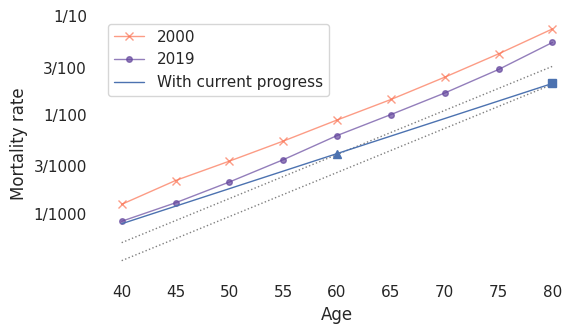

In [351]:
subset[2000].plot(lw=1, style="x-", color=Re70)
subset[2019].plot(lw=1, ms=4, style="o-", color=Pu40)

pred = make_pred(subset, results, 2040)
pred.plot(style=":", lw=1, color="gray")

pred = make_pred(subset, results, 2060)
pred.plot(style=":", lw=1, color="gray")

for x, marker in zip([60, 80], ["^", "s"]):
    y = hazard_progress[x]
    plt.plot(x, y, marker, color="C0")

hazard_progress.loc[:80].plot(lw=1, label="With current progress")

decorate(xlabel="Age", ylabel="Mortality rate", yscale="log")
add_yticks()
#decorate(title="Mortality rate in Sweden with continued progress", loc="lower right")
plt.tight_layout()
savefig('nbue12.png')

The line labeled "With current progress" indicates the mortality rates we expect for a hypothetical Swede who was 40 in 2020.
When they are 60, it will be 2040, so we expect them to have the mortality rate of a 60-year-old in 2040, indicated by a triangle.
And when they are 80, it will be 2060, so we expect them to have the mortality rate of an 80-year-old in 2060, indicated by a square.

We can use these mortality rates to compute survival curves, as shown in the following figure.

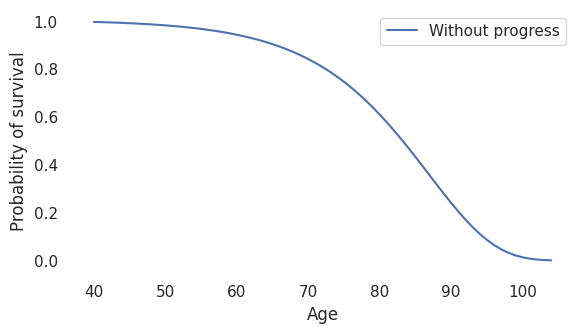

In [352]:
hazard_no_progress.make_surv().plot(label="Without progress")

decorate(
    xlabel="Age",
    ylabel="Probability of survival",
    #title="Survival curve, Sweden 2019",
)
savefig('nbue12a.png')

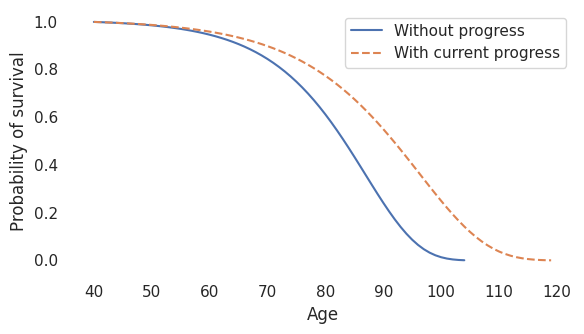

In [353]:
hazard_no_progress.make_surv().plot(label="Without progress")
hazard_progress.make_surv().plot(ls="--", label="With current progress")

decorate(
    xlabel="Age",
    ylabel="Probability of survival",
    #title="Survival curves with and without progress",
)
savefig('nbue12b.png')

In [354]:
def hypothetical_results(b2):
    """Make RegressionResults with a counterfactual slope.
    
    b2: slope
    
    returns: RegressionResults
    """
    results = smf.ols(formula, data=data).fit()
    i1, a1, b1 = results.params
    i2 = i1 + (b1 - b2) * 2019
    results.params["Intercept"] = i2
    results.params["year"] = b2
    return results

In [355]:
def hazard_hypo_progress(b2, upper):
    """Compute a Hazard function with hypothetical progress.

    b2: slope
    upper: upper end of the qs

    returns: Hazard
    """
    hypo = hypothetical_results(b2)
    pred_frame = pd.DataFrame(dtype=float)
    pred_frame["age"] = np.arange(40, upper)
    pred_frame["year"] = 2019 + pred_frame["age"] - 40
    return pred_hazard(hypo, pred_frame)

In [356]:
b2 = results.params["year"] * 2
hazard_progress2 = hazard_hypo_progress(b2, 145)

In [357]:
b3 = results.params["year"] * 3
hazard_progress3 = hazard_hypo_progress(b3, 180)

In [358]:
b4 = results.params["year"] * 4
hazard_progress4 = hazard_hypo_progress(b4, 300)

In [359]:
results.params["age"] / results.params["year"]

-4.89621102405056

In [360]:
b49 = -results.params["age"]
hazard_progress49 = hazard_hypo_progress(b49, 8000)

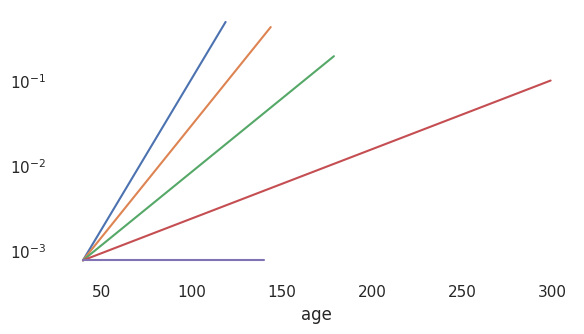

In [361]:
hazard_progress.plot()
hazard_progress2.plot()
hazard_progress3.plot()
hazard_progress4.plot()
hazard_progress49.loc[:140].plot()

decorate(yscale="log")

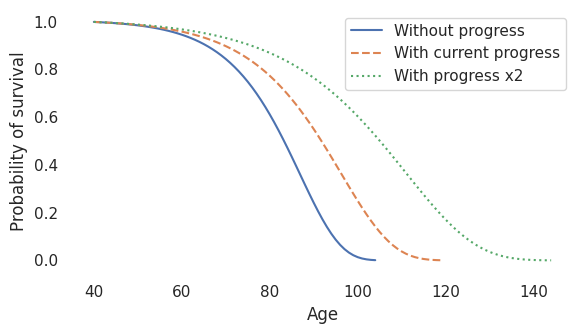

In [362]:
hazard_no_progress.make_surv().plot(ls="-", label="Without progress")
hazard_progress.make_surv().plot(ls="--", label="With current progress")
hazard_progress2.make_surv().plot(ls=":", label="With progress x2")

decorate(
    xlabel="Age",
    ylabel="Probability of survival",
    #title="Survival curves with different rates of progress",
)
savefig('nbue13.png')

The dashed line on the left shows the survival curve we expect if there is no further decrease in mortality rates; in that scenario, life expectancy at age 40 is 82 years and the probability of living to 100 is only 1.4%.

The solid line shows the survival curve if mortality continues to decrease at the current rate; in that case, life expectancy for the same 40-year-old is 90 years and the chance of living to 100 is 25%.

In [363]:
def mean(hazard):
    pmf = hazard.make_pmf()
    pmf.normalize()
    return pmf.mean()

In [364]:
mean(hazard_no_progress), mean(hazard_progress), mean(hazard_progress2)

(81.88119575997098, 90.01328388938188, 102.72010650635067)

In [365]:
mean(hazard_progress3), mean(hazard_progress4)

(125.65619219578866, 185.38884205632206)

In [366]:
hazard_no_progress.make_surv()(100)

array(0.01353305)

In [367]:
hazard_progress.make_surv()(100)

array(0.24964025)

In [368]:
hazard_progress2.make_surv()([100, 120, 130, 140])

array([0.60379629, 0.17113289, 0.03569291, 0.00159352])

Finally, the dotted line on the right shows the survival curve if mortality decreases at twice the current rate.
Life expectancy at age 40 would be 102 and the probability of living to 100 would be 60%.

The following figure shows the survival curve under the assumption that mortality rates, starting in 2019, decrease at four times the current rate.

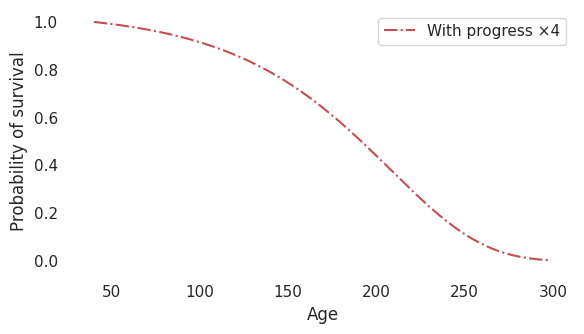

In [369]:
hazard_progress4.make_surv().plot(color="C3", ls="-.", label="With progress ×4")

decorate(
    xlabel="Age",
    ylabel="Probability of survival",
    # title="Survival curve with progress ×4",
)

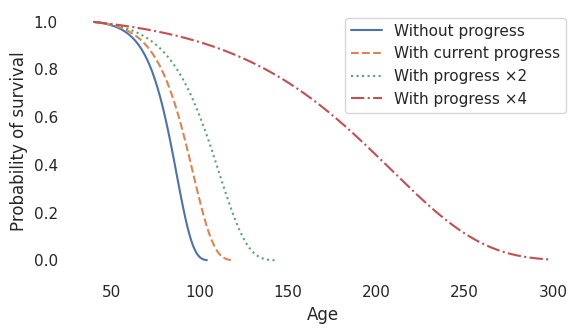

In [370]:
hazard_no_progress.make_surv().plot(ls="-", label="Without progress")
hazard_progress.make_surv().plot(ls="--", label="With current progress")
hazard_progress2.make_surv().plot(ls=":", label="With progress ×2")
hazard_progress4.make_surv().plot(color="C3", ls="-.", label="With progress ×4")

decorate(
    xlabel="Age",
    ylabel="Probability of survival",
    # title="Survival curve with 4x rate of progress",
)
savefig('nbue14.png')

In this scenario, some people live to be 300 years old!
However, even with these optimistic assumptions, the shape of the curve is similar to what we get with slower rates of progress.
And, as shown in the following figure, average remaining lifetimes decrease with almost the same slope.

In [371]:
qs = np.arange(40, hazard_progress4.qs.max())
rem_progress4 = remaining_lifetimes_pmf(hazard_progress4.make_pmf(), qs)

qs = np.arange(40, hazard_progress3.qs.max())
rem_progress3 = remaining_lifetimes_pmf(hazard_progress3.make_pmf(), qs)

qs = np.arange(40, 140)
rem_progress2 = remaining_lifetimes_pmf(hazard_progress2.make_pmf(), qs)

qs = np.arange(40, 120)
rem_progress = remaining_lifetimes_pmf(hazard_progress.make_pmf(), qs)

qs = np.linspace(40, 100)
rem_no_progress = remaining_lifetimes_pmf(hazard_no_progress.make_pmf(), qs)

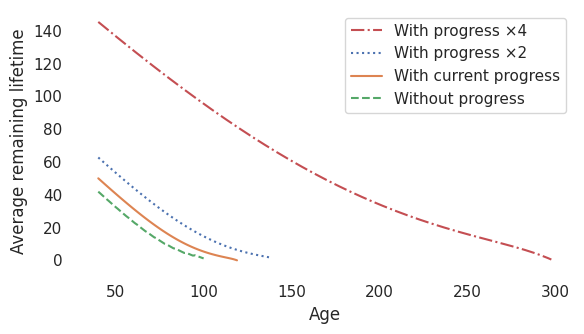

In [372]:
rem_progress4.plot(color="C3", ls="-.", label="With progress ×4")
# rem_progress3.plot(ls=':', label='With progress ×3')
rem_progress2.plot(ls=":", label="With progress ×2")
rem_progress.plot(ls="-", label="With current progress")
rem_no_progress.plot(ls="--", label="Without progress")

decorate(
    xlabel="Age",
    ylabel="Average remaining lifetime",
    # title="Average remaining lifetime with different rates of progress",
)
savefig('nbue15.png')

With faster progress, people live longer, but they still have the new-better-than-used property: as each year passes, they get closer to the grave, on average.

However, something remarkable happens if progress accelerates by a factor of 4.9.
At that speed, the increase in mortality due to aging by one year is exactly offset by the decrease due to progress.
That means that the probability of dying is the same from one year to the next, forever.
The result is a survival curve that looks like this.

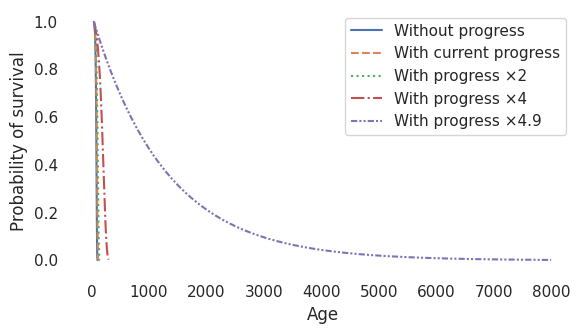

In [373]:
dashdotdot = (0, (3, 1, 1, 1, 1, 1))

hazard_no_progress.make_surv().plot(ls="-", label="Without progress")
hazard_progress.make_surv().plot(ls="--", label="With current progress")
hazard_progress2.make_surv().plot(ls=":", label="With progress ×2")
hazard_progress4.make_surv().plot(color="C3", ls="-.", label="With progress ×4")

hazard_progress49.make_surv().plot(
    color="C4", ls=dashdotdot, label="With progress ×4.9"
)

decorate(
    xlabel="Age",
    ylabel="Probability of survival",
#    title="Survival curves with progress ×4 and ×4.9 progress",
)
savefig('nbue15.png')

The difference between 4 and 4.9 is qualitative.
At a factor of 4, the survival curve plummets toward an inevitable end; at a factor of 4.9, it extends out to ages that are beyond biblical.

In [374]:
lam = hazard_no_progress[40]
lam * 1e4

7.888830027209969

In [375]:
1 / lam, 2 / lam

(1267.6150919094762, 2535.2301838189524)

In [376]:
from scipy.stats import expon

dist = expon(scale=1 / lam)
dist.mean(), dist.median()

(1267.6150919094762, 878.6438269922893)

In [377]:
dist.sf([2000, 4000])

array([0.20643576, 0.04261572])

In [378]:
dist.ppf(1 - 1 / 7e9)

28735.7893553912

In the near future, if child mortality continues to decrease, everyone will be better new than used.
But eventually, if adult mortality decreases fast enough, everyone will have the same remaining time, on average: new, used, or in between.

Probably Overthinking It

Copyright 2022 Allen Downey 

The code in this notebook and `utils.py` is under the [MIT license](https://mit-license.org/).